# Prediksi Emisi Karbon (CO2) per kapita di Indonesia

Dataset yang dianalisis dalam penelitian ini merupakan dataset dari website Worldometers yang bersumber dari Emission Database for Global Atmospheric Research (EDGAR), CO2 Emissions from Fuel Combustion - IEA, and World Population Prospects: The 2019 Revision - United Nations Population Division. Kumpulan data yang digunakan pada penelitian ini terdiri dari 2 atribut tahun dan 45 record. Dari data ini akan dilakukan training dengan metode LSTM.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_excel('/content/emisico2indo.xlsx')
df.head()

,Year,CO2 emission per kapita
0,1971,0.26
1,1972,0.30
2,1973,0.33
3,1974,0.35
4,1975,0.36


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     46 non-null     int64  
 1   CO2 emission per kapita  46 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 864.0 bytes


In [4]:
#Missing values computation

df.isnull().sum()

Year                       0
CO2 emission per kapita    0
dtype: int64

# Mengubah kolom 'Year' menjadi indeks datetime

In [5]:
df['Year'] = pd.to_datetime(df['Year'])
df.set_index('Year', inplace= True)


#Memvisualisasikan data

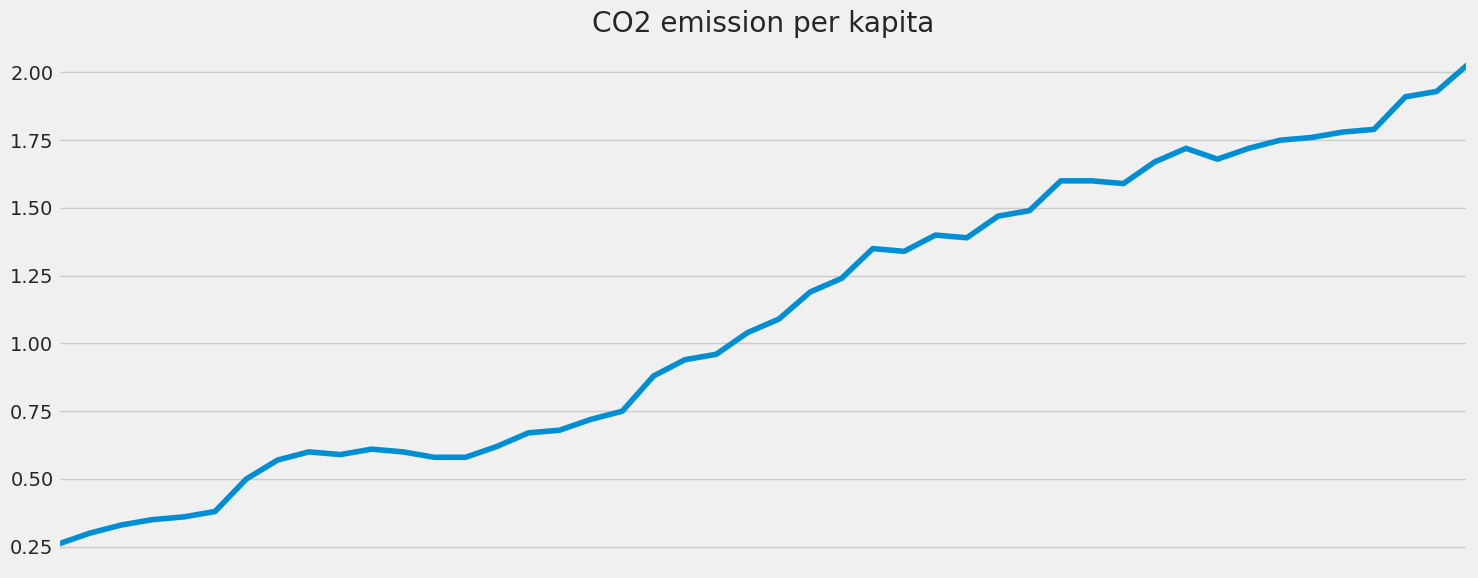

In [6]:
plt.figure(figsize=(15, 6))
df['CO2 emission per kapita'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("CO2 emission per kapita")
plt.tight_layout()
plt.show()

#Melihat data shape

In [7]:
n_cols = 1
dataset = df['CO2 emission per kapita']
dataset = pd.DataFrame(dataset)
data = dataset.values

data.shape

(46, 1)

#Melakukan komputasi MinMaxScaler
yang mempertahankan bentuk distribusi asli dengan mengurangkan nilai minimum dalam fitur lalu membagi dengan range

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data))

#Melakukan splitting data
menjadi 75:25 untuk training dan testing

In [9]:
train_size = int(len(data) * 0.75)
test_size = len(data) - train_size
print("Train Size :",train_size,"Test Size :",test_size)

Train Size : 34 Test Size : 12


In [10]:
train_data = scaled_data[0:train_size, :]
train_data.shape

(34, 1)

# Menentukan training set dengan 13 time steps.

In [11]:
x_train = []
y_train = []
time_steps = 18
n_cols = 1

for i in range(time_steps, len(scaled_data)):
    x_train.append(scaled_data[i-time_steps:i, :n_cols])
    y_train.append(scaled_data[i, :n_cols])
    if i<=time_steps:
        print('X_train: ', x_train)
        print('y_train:' , y_train)

X_train:  [array([[0.        ],
       [0.02259887],
       [0.03954802],
       [0.05084746],
       [0.05649718],
       [0.06779661],
       [0.13559322],
       [0.17514124],
       [0.1920904 ],
       [0.18644068],
       [0.19774011],
       [0.1920904 ],
       [0.18079096],
       [0.18079096],
       [0.20338983],
       [0.23163842],
       [0.23728814],
       [0.25988701]])]
y_train: [array([0.27683616])]


In [13]:
x_train, y_train = np.array(x_train), np.array(y_train)

#Training set dikonversi menjadi numpy array dan dibentuk shape-nya.

In [14]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_cols))

In [15]:
x_train.shape , y_train.shape

((28, 18, 1), (28, 1))

#Membangun model LSTM
dengan 3 layer LSTM dengan layer pertama sebesar 200 neuron, layer kedua sebesar 10 neuron dan layer ketiga sebesar 50 neuron serta layer dense dengan layer pertama sebesar 20 neuron, layer kedua sebesar 10 neuron, dan layer ketiga sebesar 1 neuron. Optimizer menggunakan optimizer adam, untuk loss terdapat mean_absolute_error.

In [18]:
model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(18, 1)))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics= "mean_absolute_error")
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 18, 200)           161600    
                                                                 
 lstm_1 (LSTM)               (None, 18, 100)           120400    
                                                                 
 lstm_2 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 20)                1020      
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 313,441
Trainable params: 313,441
Non-trai

In [19]:
def df_to_x_y(df, window_size):
    df_as_np = df.to_numpy()
    x=[]
    y=[]
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        x.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(x), np.array(y)

#Melakukan fit model
dengan epoch sebesar 100 dan ukuran batch sebesar 32

In [22]:
history = model.fit(x_train, y_train, epochs= 100, batch_size= 32)

Epoch 1/100
1/1 [==============================] - 0s 96ms/step - loss: 0.0039 - mean_absolute_error: 0.0518
Epoch 2/100
1/1 [==============================] - 0s 83ms/step - loss: 0.0039 - mean_absolute_error: 0.0517
Epoch 3/100
1/1 [==============================] - 0s 84ms/step - loss: 0.0038 - mean_absolute_error: 0.0517
Epoch 4/100
1/1 [==============================] - 0s 77ms/step - loss: 0.0038 - mean_absolute_error: 0.0516
Epoch 5/100
1/1 [==============================] - 0s 85ms/step - loss: 0.0038 - mean_absolute_error: 0.0515
Epoch 6/100
1/1 [==============================] - 0s 93ms/step - loss: 0.0038 - mean_absolute_error: 0.0513
Epoch 7/100
1/1 [==============================] - 0s 92ms/step - loss: 0.0038 - mean_absolute_error: 0.0512
Epoch 8/100
1/1 [==============================] - 0s 86ms/step - loss: 0.0038 - mean_absolute_error: 0.0510
Epoch 9/100
1/1 [==============================] - 0s 95ms/step - loss: 0.0037 - mean_absolute_error: 0.0509
Epoch 10/100
1/1 [=

#Mengukur Loss
Dari hasil dapat disimpulkan bahwa kurva model loss menunjukan hasil kurva menurun dengan baik dan tidak terjadi overfitting yang berlebihan.

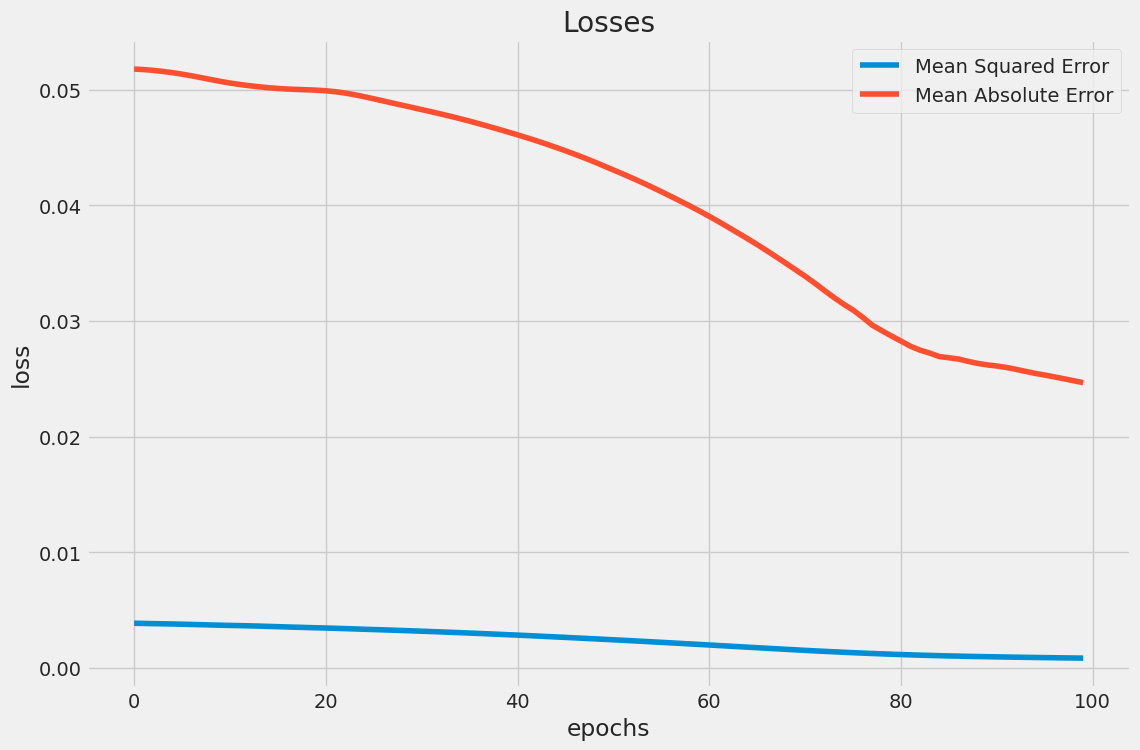

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

#Melakukan prediksi
Data test dibuatkan dengan 18 time steps, kemudian dilakukan juga standardisasi dengan scaler.inverse_transform serta mengkomputasi root mean square error.

In [24]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 18
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [25]:
# Get Prediction
predictions = model.predict(x_test)

1/1 [==============================] - 1s 505ms/step


In [26]:
predictions.shape

(12, 1)

In [27]:
#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

(12, 1)

In [28]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)

In [29]:
RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

0.02

#Plotting prediksi

In [30]:

preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts


,Predictions,Actuals
0,1.569319,1.59
1,1.613667,1.67
2,1.658644,1.72
3,1.704713,1.68
4,1.746008,1.72
5,1.786206,1.75
6,1.827364,1.76
7,1.865796,1.78
8,1.903025,1.79
9,1.935948,1.91


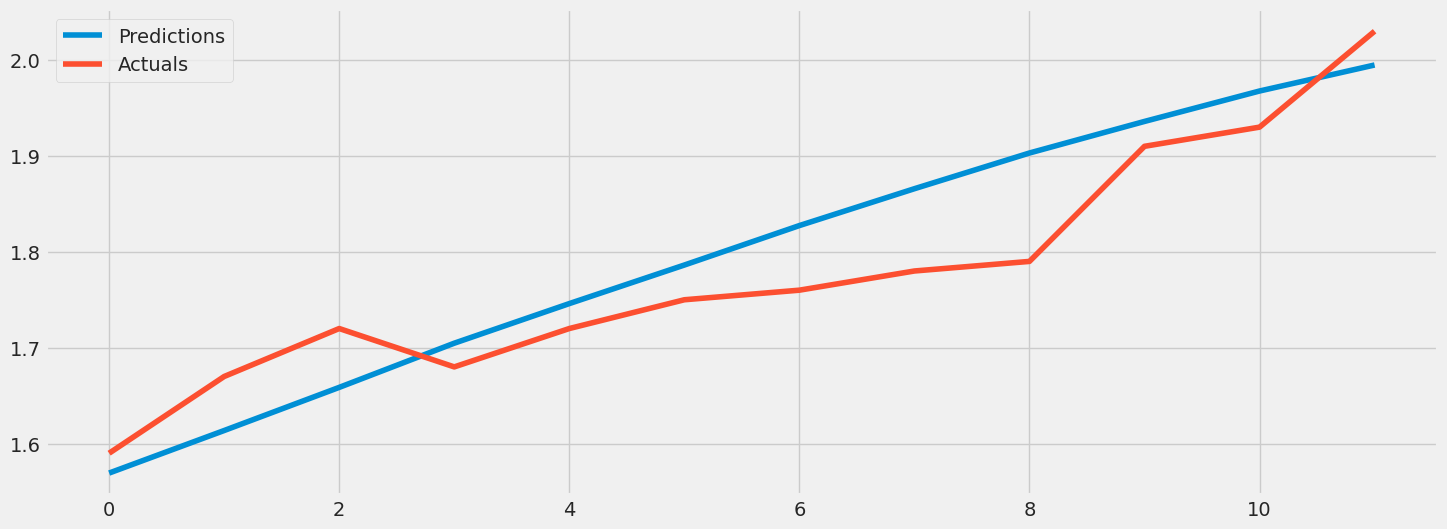

In [31]:
plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

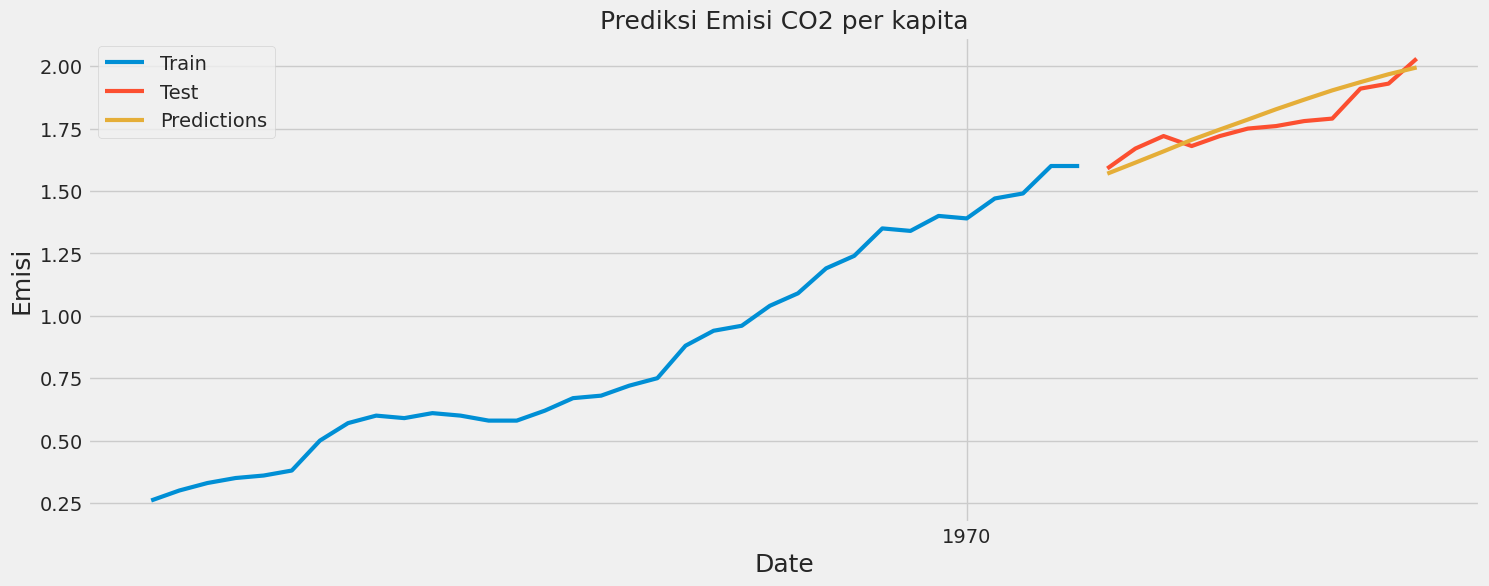

In [32]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Prediksi Emisi CO2 per kapita', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Emisi', fontsize= 18)
plt.plot(train['CO2 emission per kapita'], linewidth= 3)
plt.plot(test['CO2 emission per kapita'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

In [33]:
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [34]:
print('Test RMSE:',mean_squared_error(test['CO2 emission per kapita'], test['Predictions'])**0.5)
print('Test MAPE:',mean_absolute_percentage_error(test['CO2 emission per kapita'], test['Predictions']))

Test RMSE: 0.05625039136162248
Test MAPE: 0.02774978385223371


In [35]:
import pickle

In [37]:
#Menghasilkan file prediksi yang digunakan untuk deployment
pickle.dump(preds_acts, open('deploy.sav','wb'))